In [1]:
import pandas as pd

from eoles.utils import get_config, process_heating_need
from eoles.process_cost_efficiency import piecewise_linearization_cost_efficiency
from eoles.model_heat_coupling import ModelEOLES
import logging

from project.model import get_inputs, social_planner  # imports from ResIRF package
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# set seaborn style
sns.set_theme()

In [9]:
sns.set_theme()

In [2]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:22:27,602 - 22990 - log_ - INFO - Creating AgentBuildings object


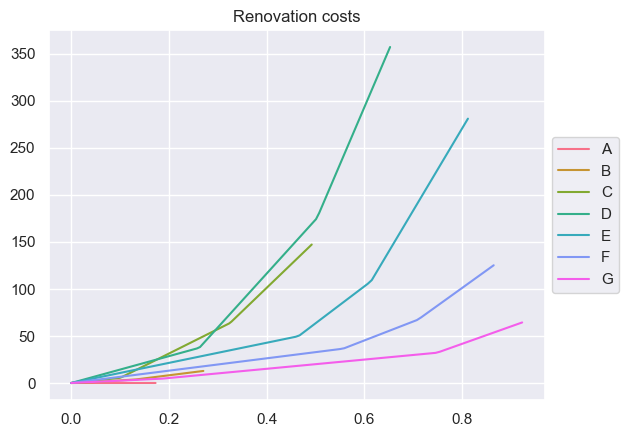

In [44]:
dict_cost, dict_heat = social_planner(aggregation_archetype=['Performance'], climate=2006, smooth=False, building_stock="medium_3")
dict_heat = process_heating_need(dict_heat, climate=2006)
linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(dict_cost, number_of_segments=3, plot=True)

In [40]:
linearized_renovation_costs

A_0       0.050838
A_1       0.260155
A_2       0.264362
B_0      14.734319
B_1      32.730230
B_2      64.299292
C_0      55.298191
C_1     259.370270
C_2     498.571182
D_0     142.660805
D_1     572.289419
D_2    1214.531429
E_0     106.899518
E_1     392.724874
E_2     871.330002
F_0      65.559942
F_1     201.273284
F_2     372.878363
G_0      24.983341
G_1      48.942577
G_2     184.657160
dtype: float64

In [29]:
dict_heat

{'Multi-family': 0       13.034792
 1       14.524482
 2       15.269328
 3       15.641750
 4       17.131441
           ...    
 8755    10.373448
 8756     9.361404
 8757     8.602371
 8758     8.349360
 8759    10.626458
 Name: Multi-family, Length: 8760, dtype: float64,
 'Single-family': 0       31.603009
 1       35.214782
 2       37.020668
 3       37.923611
 4       41.535384
           ...    
 8755    25.571801
 8756    23.076991
 8757    21.205884
 8758    20.582181
 8759    26.195503
 Name: Single-family, Length: 8760, dtype: float64}

2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Creating AgentBuildings object
2022-11-22 14:23:39,242 - 22990 - log_ - INFO - Crea

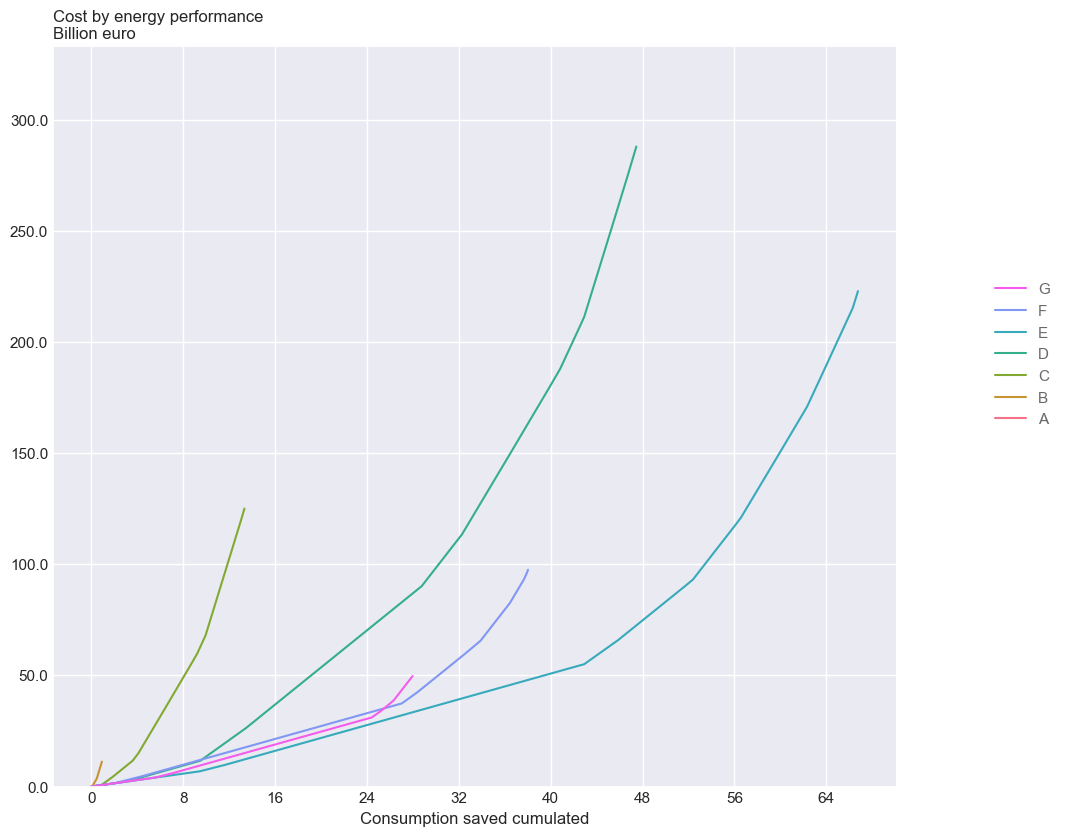

In [46]:
from project.utils import make_plots
dict_cost, dict_heat = social_planner(aggregation_archetype=['Performance'], climate=2006, smooth=False, building_stock="medium_3", percent=False)
make_plots(dict_cost, 'Cost by energy performance (Billion euro)', loc="left", left=1.15)

In [5]:
linearized_renovation_costs


Multi-family_0       74.038320
Multi-family_1      339.918501
Multi-family_2      783.122593
Single-family_0     315.485013
Single-family_1    1608.102554
Single-family_2    3523.879720
dtype: float64

In [45]:
[(a, dict_heat[a].sum()) for a in dict_heat.keys()]

[('A', 17.034698284310597),
 ('B', 3627.798307377249),
 ('C', 25248.582353184785),
 ('D', 59477.820497364315),
 ('E', 58277.31138272582),
 ('F', 28672.508101720654),
 ('G', 16697.373641782007)]

In [47]:
6/58

0.10344827586206896

In [17]:
list_scc = [0, 100, 200, 300, 400, 500]
list_social_cost = []
list_technical_cost = []
list_emissions = []
list_primary_production = []
list_heat_generation = []
renovation_rate_df = pd.DataFrame()
reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuc", "biogas1", "biogas2", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

scenario_cost_high = {
    "capex": {
        "heat_pump": 1500,
        "gas_boiler": 280
    } ,
    "conversion_efficiency": {
        "gas_boiler": 0.8
    }
}

for scc in list_scc:
    print(f"Social cost of carbon: {scc}")
    m_scc = ModelEOLES(name="test", config=config, path="eoles/outputs", logger=logger, nb_years=1, heating_demand=dict_heat, nb_linearize=3,
                       linearized_renovation_costs=linearized_renovation_costs, threshold_linearized_renovation_costs=threshold_linearized_renovation_costs,
                       social_cost_of_carbon=scc, year=2050, scenario_cost=None, hp_hourly=True, renov=None)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    list_social_cost.append(m_scc.objective)
    list_technical_cost.append(m_scc.technical_cost)
    list_emissions.append(m_scc.emissions)

    list_primary_production.append(m_scc.primary_generation.reindex(reindex_primary_prod).to_list())
    list_heat_generation.append(m_scc.heat_generation.reindex(reindex_heat_prod).to_list())
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().transpose()], axis=0, ignore_index=True)

Social cost of carbon: 0


2022-11-22 13:56:44,928 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-22 13:57:19,677 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:829: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:873: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 100


2022-11-22 13:57:34,713 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-22 13:58:09,082 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:829: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:873: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 200


2022-11-22 13:58:24,074 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-22 13:59:09,451 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:829: RuntimeWarning: divide by zero encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:873: RuntimeWarning: divide by zero encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 300


2022-11-22 13:59:24,414 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-22 13:59:59,850 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:829: RuntimeWarning: divide by zero encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:873: RuntimeWarning: divide by zero encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 400


2022-11-22 14:00:15,003 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-22 14:01:06,319 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:829: RuntimeWarning: divide by zero encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:873: RuntimeWarning: divide by zero encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 500


2022-11-22 14:01:20,700 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-22 14:02:08,019 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:829: RuntimeWarning: divide by zero encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:873: RuntimeWarning: divide by zero encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


In [18]:
m_scc.objective

42.48688122756166

In [9]:
m_scc.objective

42.486877306118465

In [8]:
list_social_cost

[2534664.193177706]

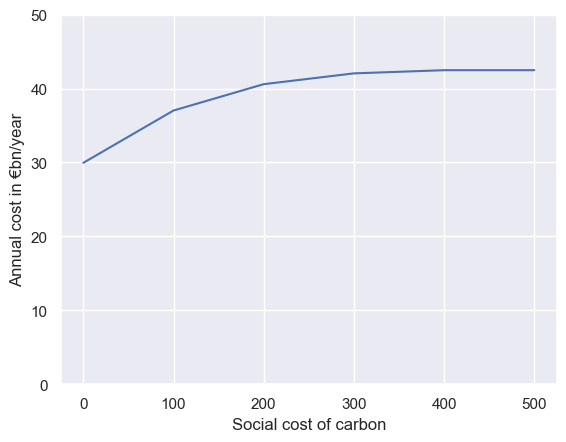

In [19]:
plt.plot(list_scc, list_social_cost)
plt.ylim(0, 50)
plt.ylabel("Annual cost in €bn/year")
plt.xlabel("Social cost of carbon")
plt.show()

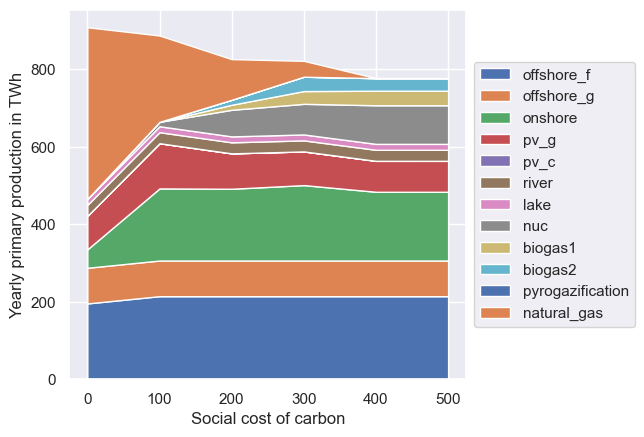

In [20]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

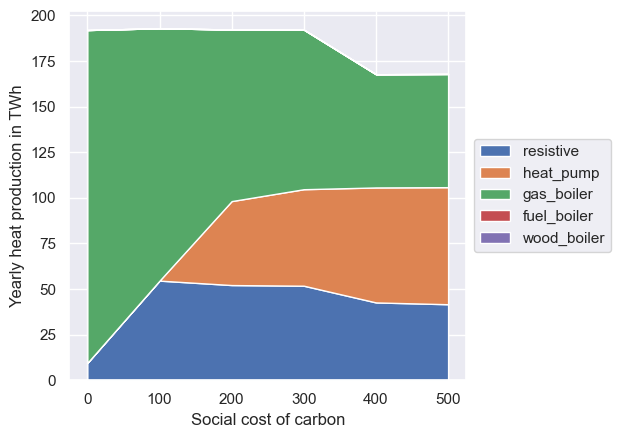

In [21]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

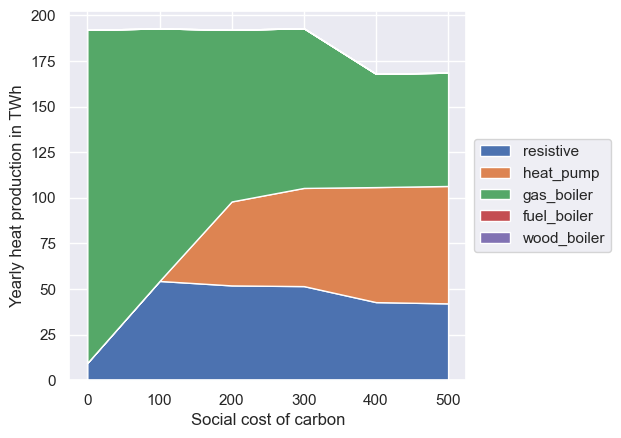

In [11]:
list_heat_generation = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [22]:
renovation_rate_df_plot = renovation_rate_df.copy()
renovation_rate_df_plot.index = list_scc
renovation_rate_df_plot = renovation_rate_df_plot.stack(level=[i for i in range(renovation_rate_df_plot.columns.nlevels)]).reset_index()
# renovation_rate_df_plot["archetype"] = renovation_rate_df_plot.apply(lambda row: row["level_1"]+ ' ' + row["level_2"], axis=1)
renovation_rate_df_plot["archetype"] = renovation_rate_df_plot.apply(lambda row: row["level_1"], axis=1)
renovation_rate_df_plot = renovation_rate_df_plot.rename(columns={"level_0": "scc", 0: "renovation_rate"})

In [23]:
renovation_rate_df_plot

,scc,level_1,renovation_rate,archetype
0,0,Multi-family,0.000000,Multi-family
1,0,Single-family,0.000000,Single-family
2,100,Multi-family,0.000000,Multi-family
3,100,Single-family,0.000000,Single-family
4,200,Multi-family,0.000000,Multi-family
5,200,Single-family,0.000000,Single-family
6,300,Multi-family,0.000000,Multi-family
7,300,Single-family,0.000000,Single-family
8,400,Multi-family,0.440728,Multi-family
9,400,Single-family,0.000000,Single-family


In [24]:
df_heat = pd.DataFrame(dict_heat).stack(
    level=[i for i in range(pd.DataFrame(dict_heat).columns.nlevels)]).reset_index()
# df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"] + ' ' + row["level_2"], axis=1)  # should be changed depending on level of multiindex
df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"], axis=1)  # should be changed depending on level of multiindex
df_heat = df_heat.rename(columns={"level_0": "date", 0: "heat_demand"})

df_heat

,date,level_1,heat_demand,archetype
0,0,Multi-family,13.034792,Multi-family
1,0,Single-family,31.603009,Single-family
2,1,Multi-family,14.524482,Multi-family
3,1,Single-family,35.214782,Single-family
4,2,Multi-family,15.269328,Multi-family
...,...,...,...,...
17515,8757,Single-family,21.205884,Single-family
17516,8758,Multi-family,8.349360,Multi-family
17517,8758,Single-family,20.582181,Single-family
17518,8759,Multi-family,10.626458,Multi-family


In [25]:
heat_and_renov = pd.merge(renovation_rate_df_plot.groupby(["archetype", "scc"])["renovation_rate"].sum().reset_index(), df_heat.groupby("archetype")["heat_demand"].sum().reset_index(),
         on='archetype')
heat_and_renov

,archetype,scc,renovation_rate,heat_demand
0,Multi-family,0,0.000000,55030.577766
1,Multi-family,100,0.000000,55030.577766
2,Multi-family,200,0.000000,55030.577766
3,Multi-family,300,0.000000,55030.577766
4,Multi-family,400,0.440728,55030.577766
5,Multi-family,500,0.440728,55030.577766
6,Single-family,0,0.000000,136987.851216
7,Single-family,100,0.000000,136987.851216
8,Single-family,200,0.000000,136987.851216
9,Single-family,300,0.000000,136987.851216


In [26]:
renov = {}
for n, g in heat_and_renov.groupby('scc'):
    renov.update({n: (g["renovation_rate"] * g["heat_demand"]).sum() / g["heat_demand"].sum()})

In [27]:
renov

{0: 0.0,
 100: 0.0,
 200: 0.0,
 300: 0.0,
 400: 0.12630828587129447,
 500: 0.12630828587129447}

In [15]:
renovation_rate_df_plot.sort_values(by="renovation_rate", ascending=False)

,scc,level_1,renovation_rate,archetype
0,0,A,0.0,A
31,400,D,0.0,D
23,300,C,0.0,C
24,300,D,0.0,D
25,300,E,0.0,E
26,300,F,0.0,F
27,300,G,0.0,G
28,400,A,0.0,A
29,400,B,0.0,B
30,400,C,0.0,C


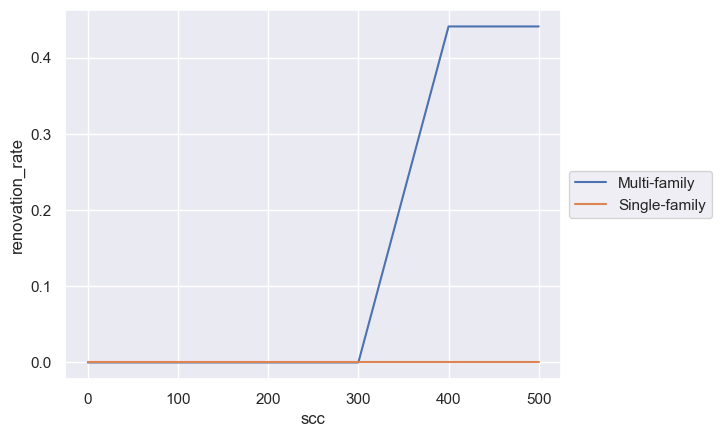

In [28]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(renovation_rate_df_plot, x="scc", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<AxesSubplot:xlabel='scc', ylabel='renovation_rate'>

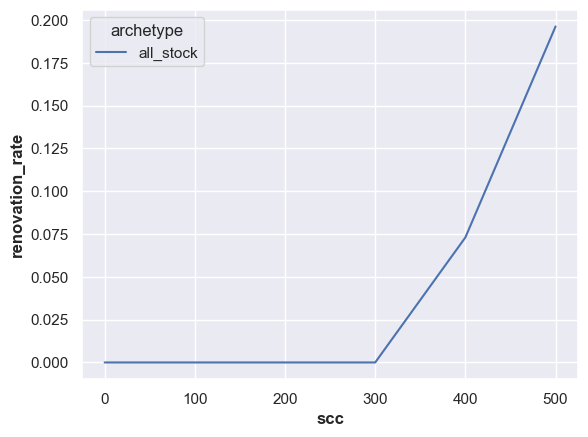

In [48]:
sns.lineplot(renovation_rate_df, x="scc", y="renovation_rate", hue="archetype")